# Stock-Forecasting

In this exercise, you will use RNNs to predict the stock market evolution.

Stock market can be seen as a sequence of values (each day could be a time step), and thus you can predict the closing value of the next day, knowing the past.

## Data exploration

First, load the dataset `all_stocks_5yr.csv`, which contains all the stock market values over 5 years for many companies. Feel free to explore it.

In [1]:
# TODO: Load the dataset and explore it
import pandas as pd

df = pd.read_csv('all_stocks_5yr.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [2]:
print("NA:", df.isna().sum())
print("duplicates:", df.duplicated().sum())

NA: open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
duplicates: 754


The column name represent the codename of the stock, for example `'AAL'` stands for American Airlines, `'AAPL'` for Apple, and so on... You can check a company by googling the codename.

Select a company for which you have enough information (i.e. a lot of datapoints, at least 1000), and plot the `close` value of this stock as a function of time. Let's say this represents the stock market evolution.

/home/vince/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


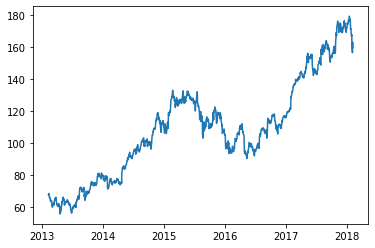

In [3]:
# TODO: Plot the stock market evolution of a given name
import numpy as np
import matplotlib.pyplot as plt

data = df[df['Name']=='AAPL'].drop(columns=['Name'])

plt.plot(data.index, data['close'])
plt.show()

> Optional: for those who want a more accurate representation of the stock market, a really common visualization is the candlesticks. One can plot them using the matplotlib finance library https://github.com/matplotlib/mplfinance

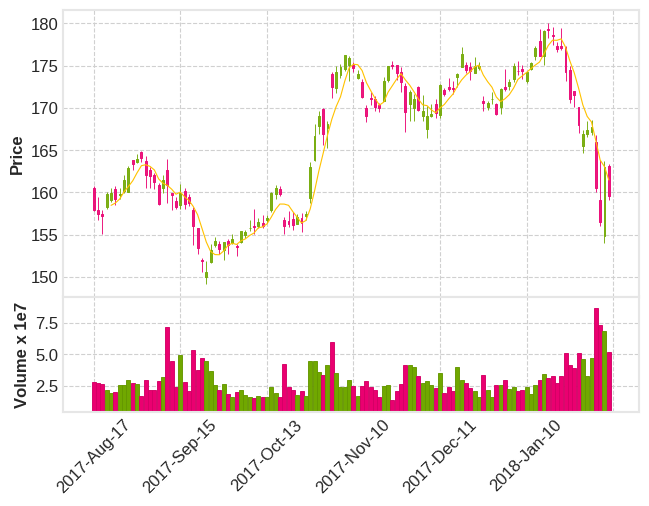

In [4]:
# Optional: plot the candlesticks
import mplfinance as mpf

mpf.plot(data[-120:], type='candle', style='binance', volume=True, mav=5)

## Data preparation

We will now try to make a prediction of this close value of a day, based on all the features (`open`, `high`, `low`, `close`, `volume`) of the 30 past days. This value of 30 days is often called the **lookback**.

But before going further, you might want to consider to rescale your data, using for example a standard scaler.

In [5]:
# TODO: normalize the data
mean = data.mean()
std = data.std()
data = (data - mean) / std
data.describe()

,open,high,low,close,volume
count,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03
mean,1.264190e-15,-2.257483e-16,-5.869455e-15,-2.122034e-15,1.354490e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.755568e+00,-1.722776e+00,-1.748979e+00,-1.743533e+00,-1.272007e+00
25%,-7.989608e-01,-8.021905e-01,-7.865013e-01,-7.931472e-01,-7.276582e-01
50%,-2.796435e-03,2.570592e-03,-3.015150e-03,-1.855511e-03,-2.503550e-01
75%,5.983646e-01,5.914349e-01,5.974545e-01,5.908110e-01,4.380502e-01
max,2.301681e+00,2.286008e+00,2.308003e+00,2.297141e+00,6.357817e+00


We now need to create the (X, y) dataset.

Let's have a example to understand what to do:

First, let's consider your action `Name` has 100 lines for the example.

Since you need the past 30 days to predict a value, you are not able to perform any prediction in the first 30 days.

Then the `X` values should contain, in each line, a table of 30 days and 5 features (`open`, `high`, `low`, `close`, `volume`). So that the final `X` array will have the shape `(70, 30, 5)`:
- 70 is the number of samples, and is 100 days minus 30 for the lookback
- 30 for the past 30 days, this is the lookback
- 5 for the features `open`, `high`, `low`, `close`, `volume`

This `y` values should be the `close` values of the days 31 to last (indeed, `y` can not contain the 30 first days, since we need 30 days of X to predict anything). So the final `y` array will have the shape `(70, 1)` (or equivalently `(70,)`).

In [6]:
# TODO: compute X and y
def processData(data, past):
    X,Y = [],[]
    for i in range(len(data)-past-1):
        X.append(data.iloc[i:i+past, :].values)
        Y.append(data.iloc[i+past, 3])

    return np.array(X),np.array(Y)
lookback = 30

X, y = processData(data, lookback)
X.shape, y.shape

((1228, 30, 5), (1228,))

You already know the next step: split the data. 
> Be careful, we need to keep the order in sequence!

In [7]:
# TODO: Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((982, 30, 5), (246, 30, 5), (982,), (246,))

## Model training and evaluation

Now that the data is ready, build a RNN model (for example begin with 2 layers of 16 units), compile it and train it.

In [8]:
# TODO: Build and train your RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


def my_RNN():

    
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=(lookback,5)))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(LSTM(units=32, return_sequences=False))

    model.add(Dense(units=1, activation='linear'))

    return model

model = my_RNN()

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [ModelCheckpoint('best_model.h5',
                             save_best_only=True,
                             monitor='val_loss'),
             EarlyStopping(patience=50)]

model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=500, batch_size=128, callbacks=callbacks)

Train on 982 samples, validate on 246 samples
Epoch 1/500
982/982 [==============================] - 7s 7ms/sample - loss: 0.3481 - mae: 0.4534 - val_loss: 1.8027 - val_mae: 1.2841
Epoch 2/500
982/982 [==============================] - 0s 310us/sample - loss: 0.0907 - mae: 0.2520 - val_loss: 1.1909 - val_mae: 1.0201
Epoch 3/500
982/982 [==============================] - 0s 326us/sample - loss: 0.0524 - mae: 0.1831 - val_loss: 1.0956 - val_mae: 0.9767
Epoch 4/500
982/982 [==============================] - 0s 477us/sample - loss: 0.0423 - mae: 0.1612 - val_loss: 0.9702 - val_mae: 0.9148
Epoch 5/500
982/982 [==============================] - 0s 389us/sample - loss: 0.0314 - mae: 0.1385 - val_loss: 0.9216 - val_mae: 0.8940
Epoch 6/500
982/982 [==============================] - 0s 433us/sample - loss: 0.0248 - mae: 0.1246 - val_loss: 0.9299 - val_mae: 0.9047
Epoch 7/500
982/982 [==============================] - 0s 445us/sample - loss: 0.0234 - mae: 0.1219 - val_loss: 0.8391 - val_mae: 0.85

982/982 [==============================] - 0s 355us/sample - loss: 0.0078 - mae: 0.0696 - val_loss: 0.1270 - val_mae: 0.2730
Epoch 61/500
982/982 [==============================] - 0s 353us/sample - loss: 0.0075 - mae: 0.0682 - val_loss: 0.1075 - val_mae: 0.2471
Epoch 62/500
982/982 [==============================] - 0s 354us/sample - loss: 0.0073 - mae: 0.0671 - val_loss: 0.1091 - val_mae: 0.2495
Epoch 63/500
982/982 [==============================] - 0s 353us/sample - loss: 0.0072 - mae: 0.0669 - val_loss: 0.1216 - val_mae: 0.2669
Epoch 64/500
982/982 [==============================] - 0s 352us/sample - loss: 0.0072 - mae: 0.0666 - val_loss: 0.0997 - val_mae: 0.2375
Epoch 65/500
982/982 [==============================] - 0s 351us/sample - loss: 0.0070 - mae: 0.0648 - val_loss: 0.1081 - val_mae: 0.2486
Epoch 66/500
982/982 [==============================] - 0s 386us/sample - loss: 0.0069 - mae: 0.0652 - val_loss: 0.1172 - val_mae: 0.2617
Epoch 67/500
982/982 [=========================

In [11]:
model.load_weights('best_model.h5')

Plot the results: display on the same plot `y_train`, `y_test` and the prediction of `y_test`.

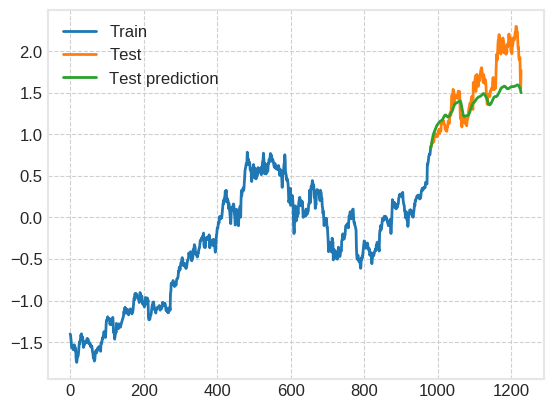

In [12]:
# TODO: Plot the results
plt.plot(np.arange(len(X_train)), y_train, label='Train')
plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), y_test, label='Test')
plt.plot(np.arange(len(X_train), len(X_train)+len(X_test), 1), model.predict(X_test), label='Test prediction')
plt.legend()
plt.show()

You can try to improve your model by adding as features the information of other actions. As you know, in stock market, most of the information that impacts it is out of the stock market information itself.

## Backtesting

In real life, traders backtest a trading strategy in order to check if it works.

The principle is the following:
- You define a strategy: for example buy when prediction of next day increases, sell when prediction of next day decreases
- You test this strategy on test dataset with real data, with a given amount of money for start
- You compare your relative return to the market return
- If the relative return is greater than 1, and you don't lose money at the end, your strategy is worth trying in real life

Feel free to implement a backtesting of your model with a given strategy.